<a href="https://colab.research.google.com/github/heesukjang/W266_NLP_With_DeepLearning/blob/main/Final_Project/v2_onlyRegression_withBERT_3_25_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install New Libraries**

In [44]:
!pip install nltk
!pip install wordcloud
!pip install transformers

NotImplementedError: ignored

# **Importing Libraries**

In [ ]:
import random

#NLP related libraries
import transformers
print(f'transformers version: {transformers.__version__}')
from transformers import logging as hf_logging
from transformers import BertTokenizer, TFBertModel
hf_logging.set_verbosity_error()
import nltk
from nltk.tokenize import sent_tokenize
import spacy      
from spacy import displacy
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from wordcloud import ImageColorGenerator
from sklearn.model_selection import train_test_split
nltk.download('punkt')

# Other required libraries
import os
import pandas as pd
import numpy as np
import re
import copy
import sys
import warnings
warnings.filterwarnings("ignore")

# Data visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.layer_utils import count_params
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import mae
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.losses import binary_crossentropy
from keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from keras.models import load_model

from google.colab import drive
drive.mount('/content/gdrive')

# **General Functions**

## **Set Config Parameters**

In [ ]:
def set_config_param(seed = 99):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.backend.clear_session()
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_columns', None)
    
    
set_config_param(20230214)

## **Count Plot**

In [ ]:
def plot_count(df, labels):
  sns.set_style('whitegrid')
  plt.figure(figsize=(18,10))
  for idx, label in enumerate(labels):
      plt.subplot(2, 3, idx+1)
      sns.countplot(x = label, data = df)

## **Adding Feature Columns**

In [ ]:
def add_feature(df):

    # Cleaning up full_text : Removing tabl and carriage return characters
    df['full_text'] = df["full_text"].replace(re.compile(r'[\n\r\t]'), ' ', regex=True)

    # Adding word count, sentence count, total score and full text length
    df['word_count'] = df['full_text'].apply(lambda x: len(x.split()))
    df['sentence_count'] = df['full_text'].apply(lambda x: len(sent_tokenize(x)))
    df['total_score'] = df['cohesion'] + df_train['syntax'] + df['vocabulary'] + df['phraseology'] + df['grammar'] + df['conventions']
    df['full_text_len'] = df['full_text'].apply(lambda x: len(x))

    # Adding mean, median score per label and indicator column 
    # whether the label value is below or above mean or median value
    for label in label_cols:
        df[label + '_avg_score'] = np.mean(df[label])
        df[label + '_above_or_below_avg_flag'] = np.where(df[label] > np.mean(df[label]), 1, 0)  
        df[label + '_median_score'] = np.median(df[label])
        df[label + '_above_or_below_median_flag'] = np.where(df[label] > np.median(df[label]), 1, 0)  
        df[label + '_rounded_val'] = np.round(df[label])  
    
    return df

## **Getting Unique Values for Each Label**

In [ ]:
def get_unique_values_for_labels(df, col_list):
    print('Unique Values in Each Metric:\n==================================================')
    for col in col_list:
        print(f'{col}: {df[col].unique()}')

## **Getting Value Counts for Each Label**

In [ ]:
def get_value_counts_for_labels(df, col_list):
    print('Counts for Each Metric:\n==================================================')
    for col in col_list:
        print(f"Column: {col}")
        print(f'{df[col].value_counts().sort_values()}')
        print("*****")

## **Getting Histogram for a Column**

In [45]:
def get_histogram_for_col(df, col_list, col_name):
    sns.set_style('whitegrid')
    plt.figure(figsize=(18,10))
    for idx, label in enumerate(col_list):
        plt.subplot(2, 3, idx+1)
        sns.histplot(x=col_name, hue = label, data = df)
        plt.xlabel('Word Count', fontsize=10)

## **Getting Count Plot for Indicator Columns**

In [46]:
def get_count_plot_for_ind_col(df, search_string, col_list):
    fig, ax = plt.subplots(1, len(col_list), figsize=(50,10))
    for idx, label in enumerate(col_list):
        sns.countplot(x = df[label + search_string], ax = ax[idx])
        ax[idx].set_title(label)

## **Getting Bar Plot for Each Label**

In [47]:
def get_barplot_for_each_label(df, col_list, search_string):
    avg_score_cols = [col + search_string for col in col_list]
    plt.figure(figsize=(8,5))
    ax = sns.barplot(x=col_list, y=np.array(df[avg_score_cols].drop_duplicates())[0], palette='rocket')
    plt.xlabel('Scoring Metric', fontsize=12)
    if search_string == '_avg_score':
        plt.ylabel('Average Score', fontsize=12)
        plt.title('Average Score in Each Metric', fontsize=16)
    elif search_string == '_median_score':
        plt.ylabel('Median Score', fontsize=12)
        plt.title('Median Score in Each Metric', fontsize=16)

## **Label Processing**

In [48]:
def get_cat_label_cols(col_list):
    return ['cat_' + col for col in col_list]

In [49]:
def apply_label_map(df, label_map, col_list):
  for col in col_list:
      df[col + '_map'] = df[col].map(label_map)
  return df

In [50]:
def get_label_values(df, col_list):
    return [np.array(df[col]) for col in col_list]

In [51]:
def get_label_dict(df, col_list_1, col_list_2):
    return dict(zip(col_list_2, get_label_values(df, col_list_1)))

## **Plot Loss and Accuracy**

In [52]:
def plot_loss_accuracy(history, col_list):
    fig, ax = plt.subplots(2, 6, figsize=(16, 6), sharex='col', sharey='row')
    fig.tight_layout(pad=5.0)
    for idx, col in enumerate(col_list):

        ax[0, idx].plot(history[col + '_loss'], lw=2, color='darkgoldenrod')
        ax[0, idx].plot(history['val_' + col + '_loss'], lw=2, color='indianred')
        #ax[0, idx].legend(loc='center left')
        ax[0, idx].legend(['Train', 'Validation'], fontsize=5)
        ax[0, idx].set_xlabel('Epochs', size=10)
        ax[0, idx].set_title('Loss: ' + col)

        ax[1, idx].plot(history[col + '_accuracy'], lw=2, color='darkgoldenrod')
        ax[1, idx].plot(history['val_' + col + '_accuracy'], lw=2, color='indianred')
        #ax[0, idx].legend(loc='center left')
        ax[1, idx].legend(['Train', 'Validation'], fontsize=5)
        ax[1, idx].set_xlabel('Epochs', size=10)
        ax[1, idx].set_title('Accuracy: ' + col)

##**Custom Metric**

In [53]:
def MCRMSE(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=-1, keepdims=True)

# **Read Input Files**

In [54]:
train_path = '/content/gdrive/MyDrive/Kaggle/train.csv'
test_path = '/content/gdrive/MyDrive/Kaggle/test.csv'

input_train_df = pd.read_csv(train_path)
input_test_df = pd.read_csv(test_path)

# input_train_df = pd.read_csv('train.csv')
# input_test_df = pd.read_csv('test.csv')

float_labels, int_map_labels = np.arange(1, 5.5, 0.5), np.arange(9)
label_map = dict(zip(float_labels, int_map_labels))

float_scaled_labels, int_scaled_labels = np.arange(1, 6, 1), np.arange(6)
label_scaled_map = dict(zip(float_scaled_labels, int_scaled_labels))

orig_train_df = copy.deepcopy(input_train_df)
orig_train_df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


"Map" columns are basically scaled columns of the original metric values. There are total 9 levels in map columns. Original mretric columns range from 1 to 5. Through map columns, they range from 0 to 8.

"Scaled" columns map numbers .5, 1.5, 2.5, 3.5 and 4.5 to nearset integers. Thus it will have range from 1 to 5.

In [55]:
label_map

{1.0: 0, 1.5: 1, 2.0: 2, 2.5: 3, 3.0: 4, 3.5: 5, 4.0: 6, 4.5: 7, 5.0: 8}

In [56]:
label_scaled_map

{1: 0, 2: 1, 3: 2, 4: 3, 5: 4}

# **Spliting the Data**

Original test data is very limited, there are only 3 records and it does not have labels to test. So we decided to repurpose the given train data to split into train, test and validation sets.

In [57]:
shuffle = np.random.permutation(np.arange(orig_train_df.shape[0]))
orig_train_df = orig_train_df.iloc[shuffle]
split=(0.8,0.1,0.1)
splits = np.multiply(len(orig_train_df), split).astype(int)
df_train, df_val, df_test = np.split(orig_train_df, [splits[0], splits[0] + splits[1]])
df_train.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
701,35D50C79C5CB,Studies have shown that one way to improve stu...,3.5,3.0,3.5,3.5,4.0,4.0
550,2A18E2265D9E,I disagree that schools board plan should not ...,4.0,3.0,3.0,3.0,3.5,4.0
2616,C1F640A29D37,"Dear Barcelona FC,\n\nIm a student from the sc...",3.5,3.5,3.5,4.0,4.0,2.5
988,4BBB3BA80E0E,Hello my name is Generic_Name. Im grateful to ...,3.5,3.5,3.0,3.0,3.0,3.0
1987,9653A4188D80,I think we choose our character traits and we ...,3.0,3.5,3.0,3.0,4.0,3.5


In [58]:
label_cols = df_train.columns[2:]
print(label_cols)
label_rounded_cols = [col + '_rounded_val' for col in label_cols]
label_map_cols = [col + '_map' for col in label_cols]
cat_label_cols = get_cat_label_cols(label_cols)

df_train = apply_label_map(df_train, label_map, label_cols)
df_test = apply_label_map(df_test, label_map, label_cols)
df_val = apply_label_map(df_val, label_map, label_cols)

Index(['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar',
       'conventions'],
      dtype='object')


In [59]:
label_cols, label_rounded_cols, label_map_cols, cat_label_cols

(Index(['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar',
        'conventions'],
       dtype='object'),
 ['cohesion_rounded_val',
  'syntax_rounded_val',
  'vocabulary_rounded_val',
  'phraseology_rounded_val',
  'grammar_rounded_val',
  'conventions_rounded_val'],
 ['cohesion_map',
  'syntax_map',
  'vocabulary_map',
  'phraseology_map',
  'grammar_map',
  'conventions_map'],
 ['cat_cohesion',
  'cat_syntax',
  'cat_vocabulary',
  'cat_phraseology',
  'cat_grammar',
  'cat_conventions'])

# **Addiung Other Feature Columns**

In [60]:
df_train = add_feature(df_train)
df_test = add_feature(df_test)
df_val = add_feature(df_val)

# **EDA**

In [61]:
df_train.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,cohesion_map,syntax_map,vocabulary_map,phraseology_map,grammar_map,conventions_map,word_count,sentence_count,total_score,full_text_len,cohesion_avg_score,cohesion_above_or_below_avg_flag,cohesion_median_score,cohesion_above_or_below_median_flag,cohesion_rounded_val,syntax_avg_score,syntax_above_or_below_avg_flag,syntax_median_score,syntax_above_or_below_median_flag,syntax_rounded_val,vocabulary_avg_score,vocabulary_above_or_below_avg_flag,vocabulary_median_score,vocabulary_above_or_below_median_flag,vocabulary_rounded_val,phraseology_avg_score,phraseology_above_or_below_avg_flag,phraseology_median_score,phraseology_above_or_below_median_flag,phraseology_rounded_val,grammar_avg_score,grammar_above_or_below_avg_flag,grammar_median_score,grammar_above_or_below_median_flag,grammar_rounded_val,conventions_avg_score,conventions_above_or_below_avg_flag,conventions_median_score,conventions_above_or_below_median_flag,conventions_rounded_val
701,35D50C79C5CB,Studies have shown that one way to improve stu...,3.5,3.0,3.5,3.5,4.0,4.0,5,4,5,5,6,6,190,7,21.5,1002,3.129636,1,3.0,1,4.0,3.029572,0,3.0,0,3.0,3.234495,1,3.0,1,4.0,3.11509,1,3.0,1,4.0,3.030691,1,3.0,1,4.0,3.08296,1,3.0,1,4.0
550,2A18E2265D9E,I disagree that schools board plan should not ...,4.0,3.0,3.0,3.0,3.5,4.0,6,4,4,4,5,6,315,19,20.5,1634,3.129636,1,3.0,1,4.0,3.029572,0,3.0,0,3.0,3.234495,0,3.0,0,3.0,3.11509,0,3.0,0,3.0,3.030691,1,3.0,1,4.0,3.08296,1,3.0,1,4.0
2616,C1F640A29D37,"Dear Barcelona FC, Im a student from the scho...",3.5,3.5,3.5,4.0,4.0,2.5,5,5,5,6,6,3,363,18,21.0,1935,3.129636,1,3.0,1,4.0,3.029572,1,3.0,1,4.0,3.234495,1,3.0,1,4.0,3.11509,1,3.0,1,4.0,3.030691,1,3.0,1,4.0,3.08296,0,3.0,0,2.0
988,4BBB3BA80E0E,Hello my name is Generic_Name. Im grateful to ...,3.5,3.5,3.0,3.0,3.0,3.0,5,5,4,4,4,4,374,19,19.0,1921,3.129636,1,3.0,1,4.0,3.029572,1,3.0,1,4.0,3.234495,0,3.0,0,3.0,3.11509,0,3.0,0,3.0,3.030691,0,3.0,0,3.0,3.08296,0,3.0,0,3.0
1987,9653A4188D80,I think we choose our character traits and we ...,3.0,3.5,3.0,3.0,4.0,3.5,4,5,4,4,6,5,378,10,20.0,2035,3.129636,0,3.0,0,3.0,3.029572,1,3.0,1,4.0,3.234495,0,3.0,0,3.0,3.11509,0,3.0,0,3.0,3.030691,1,3.0,1,4.0,3.08296,1,3.0,1,4.0


In [62]:
for col in label_cols:
    print(df_train[col + '_rounded_val'].unique())

[4. 3. 2. 5. 1.]
[3. 4. 2. 1. 5.]
[4. 3. 2. 5. 1.]
[4. 3. 2. 5. 1.]
[4. 3. 2. 5. 1.]
[4. 2. 3. 5. 1.]


In [63]:
df_train.iloc[0]

text_id                                                                        35D50C79C5CB
full_text                                 Studies have shown that one way to improve stu...
cohesion                                                                                3.5
syntax                                                                                  3.0
vocabulary                                                                              3.5
phraseology                                                                             3.5
grammar                                                                                 4.0
conventions                                                                             4.0
cohesion_map                                                                              5
syntax_map                                                                                4
vocabulary_map                                                                  

In [64]:
df_test.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,cohesion_map,syntax_map,vocabulary_map,phraseology_map,grammar_map,conventions_map,word_count,sentence_count,total_score,full_text_len,cohesion_avg_score,cohesion_above_or_below_avg_flag,cohesion_median_score,cohesion_above_or_below_median_flag,cohesion_rounded_val,syntax_avg_score,syntax_above_or_below_avg_flag,syntax_median_score,syntax_above_or_below_median_flag,syntax_rounded_val,vocabulary_avg_score,vocabulary_above_or_below_avg_flag,vocabulary_median_score,vocabulary_above_or_below_median_flag,vocabulary_rounded_val,phraseology_avg_score,phraseology_above_or_below_avg_flag,phraseology_median_score,phraseology_above_or_below_median_flag,phraseology_rounded_val,grammar_avg_score,grammar_above_or_below_avg_flag,grammar_median_score,grammar_above_or_below_median_flag,grammar_rounded_val,conventions_avg_score,conventions_above_or_below_avg_flag,conventions_median_score,conventions_above_or_below_median_flag,conventions_rounded_val
284,150C42083D49,The schools lunch menu should stay the same. S...,3.5,4.5,4.0,4.0,4.5,4.0,5,7,6,6,7,6,395,27,NaN,2245,3.145408,1,3.0,1,4.0,3.048469,1,3.0,1,4.0,3.270408,1,3.0,1,4.0,3.168367,1,3.0,1,4.0,3.059949,1,3.0,1,4.0,3.094388,1,3.0,1,4.0
3305,E52BA6E4D7EE,Technology in people's live. Technology have ...,3.5,2.0,3.0,2.5,2.5,2.5,5,2,4,3,3,3,379,5,NaN,1989,3.145408,1,3.0,1,4.0,3.048469,0,3.0,0,2.0,3.270408,0,3.0,0,3.0,3.168367,0,3.0,0,2.0,3.059949,0,3.0,0,2.0,3.094388,0,3.0,0,2.0
750,39B6454376C8,"Dear TEACHER_NAME, I'm writing this letter to...",3.0,2.5,3.5,3.0,3.0,3.5,4,3,5,4,4,5,241,5,NaN,1357,3.145408,0,3.0,0,3.0,3.048469,0,3.0,0,2.0,3.270408,1,3.0,1,4.0,3.168367,0,3.0,0,3.0,3.059949,0,3.0,0,3.0,3.094388,1,3.0,1,4.0
2278,AA416CED237D,I think some people might find visiting a nati...,3.5,3.5,3.5,3.5,4.0,3.5,5,5,5,5,6,5,482,7,NaN,2659,3.145408,1,3.0,1,4.0,3.048469,1,3.0,1,4.0,3.270408,1,3.0,1,4.0,3.168367,1,3.0,1,4.0,3.059949,1,3.0,1,4.0,3.094388,1,3.0,1,4.0
578,2BE976C99FDF,Many people like Philosopher's are stating Inf...,3.5,3.0,4.0,3.0,3.5,3.0,5,4,6,4,5,4,435,14,NaN,2455,3.145408,1,3.0,1,4.0,3.048469,0,3.0,0,3.0,3.270408,1,3.0,1,4.0,3.168367,0,3.0,0,3.0,3.059949,1,3.0,1,4.0,3.094388,0,3.0,0,3.0


In [65]:
df_val.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,cohesion_map,syntax_map,vocabulary_map,phraseology_map,grammar_map,conventions_map,word_count,sentence_count,total_score,full_text_len,cohesion_avg_score,cohesion_above_or_below_avg_flag,cohesion_median_score,cohesion_above_or_below_median_flag,cohesion_rounded_val,syntax_avg_score,syntax_above_or_below_avg_flag,syntax_median_score,syntax_above_or_below_median_flag,syntax_rounded_val,vocabulary_avg_score,vocabulary_above_or_below_avg_flag,vocabulary_median_score,vocabulary_above_or_below_median_flag,vocabulary_rounded_val,phraseology_avg_score,phraseology_above_or_below_avg_flag,phraseology_median_score,phraseology_above_or_below_median_flag,phraseology_rounded_val,grammar_avg_score,grammar_above_or_below_avg_flag,grammar_median_score,grammar_above_or_below_median_flag,grammar_rounded_val,conventions_avg_score,conventions_above_or_below_avg_flag,conventions_median_score,conventions_above_or_below_median_flag,conventions_rounded_val
1547,76F0144EB703,Why should people make their own decision? I t...,2.0,2.5,2.5,2.0,2.0,2.0,2,3,3,2,2,2,433,29,NaN,2239,3.088235,0,3.0,0,2.0,2.997442,0,3.0,0,2.0,3.210997,0,3.0,0,2.0,3.079284,0,3.0,0,2.0,3.023018,0,3.0,0,2.0,3.05243,0,3.0,0,2.0
2587,BFD5F32AA3C2,People should make their decisions because fir...,3.5,2.5,3.0,3.0,3.0,3.0,5,3,4,4,4,4,292,9,NaN,1779,3.088235,1,3.0,1,4.0,2.997442,0,3.0,0,2.0,3.210997,0,3.0,0,3.0,3.079284,0,3.0,0,3.0,3.023018,0,3.0,0,3.0,3.05243,0,3.0,0,3.0
2208,A4BBB301E3CE,I agree with what Winston Churchill said becau...,4.0,3.5,3.5,4.0,4.0,4.0,6,5,5,6,6,6,395,15,NaN,2067,3.088235,1,3.0,1,4.0,2.997442,1,3.0,1,4.0,3.210997,1,3.0,1,4.0,3.079284,1,3.0,1,4.0,3.023018,1,3.0,1,4.0,3.05243,1,3.0,1,4.0
156,0BDADA3AFF77,When someone is confused like a problem or a s...,3.0,3.0,3.0,3.0,3.0,3.5,4,4,4,4,4,5,257,11,NaN,1370,3.088235,0,3.0,0,3.0,2.997442,1,3.0,0,3.0,3.210997,0,3.0,0,3.0,3.079284,0,3.0,0,3.0,3.023018,0,3.0,0,3.0,3.05243,1,3.0,1,4.0
2811,CD5F70E5C1D7,"To begin with, in my opinion i think students ...",3.0,3.5,3.5,3.5,3.5,3.0,4,5,5,5,5,4,400,9,NaN,2099,3.088235,0,3.0,0,3.0,2.997442,1,3.0,1,4.0,3.210997,1,3.0,1,4.0,3.079284,1,3.0,1,4.0,3.023018,1,3.0,1,4.0,3.05243,0,3.0,0,3.0


In [66]:
df_train.shape, df_test.shape, df_val.shape

((3128, 48), (392, 48), (391, 48))

In [67]:
df_train.describe()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions,cohesion_map,syntax_map,vocabulary_map,phraseology_map,grammar_map,conventions_map,word_count,sentence_count,total_score,full_text_len,cohesion_avg_score,cohesion_above_or_below_avg_flag,cohesion_median_score,cohesion_above_or_below_median_flag,cohesion_rounded_val,syntax_avg_score,syntax_above_or_below_avg_flag,syntax_median_score,syntax_above_or_below_median_flag,syntax_rounded_val,vocabulary_avg_score,vocabulary_above_or_below_avg_flag,vocabulary_median_score,vocabulary_above_or_below_median_flag,vocabulary_rounded_val,phraseology_avg_score,phraseology_above_or_below_avg_flag,phraseology_median_score,phraseology_above_or_below_median_flag,phraseology_rounded_val,grammar_avg_score,grammar_above_or_below_avg_flag,grammar_median_score,grammar_above_or_below_median_flag,grammar_rounded_val,conventions_avg_score,conventions_above_or_below_avg_flag,conventions_median_score,conventions_above_or_below_median_flag,conventions_rounded_val
count,3128.000000,3128.000000,3128.000000,3128.00000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.0,3128.000000,3128.000000,3128.000000,3128.000000,3128.0,3128.000000,3128.000000,3128.000000,3128.000000,3128.0,3128.000000,3128.000000,3.128000e+03,3128.000000,3128.0,3128.000000,3128.000000,3128.000000,3128.000000,3128.0,3128.000000,3128.000000,3128.00000,3128.000000,3128.0,3128.000000,3128.000000
mean,3.129636,3.029572,3.234495,3.11509,3.030691,3.082960,4.259271,4.059143,4.468990,4.230179,4.061381,4.165921,429.276215,18.285486,18.622442,2325.288683,3.129636,0.423593,3.0,0.423593,3.141944,3.029572,0.348146,3.0,0.348146,3.022698,3.234495,0.442455,3.0,0.442455,3.283887,3.115090e+00,0.412404,3.0,0.412404,3.119246,3.030691,0.380115,3.0,0.380115,3.018542,3.08296,0.394501,3.0,0.394501,3.085358
std,0.657831,0.638924,0.578157,0.65488,0.698244,0.666533,1.315662,1.277847,1.156314,1.309759,1.396489,1.333067,193.335886,10.366240,3.341486,1039.939247,0.000000,0.494207,0.0,0.494207,0.848064,0.000000,0.476459,0.0,0.476459,0.835223,0.000000,0.496757,0.0,0.496757,0.752335,4.441602e-16,0.492346,0.0,0.492346,0.849862,0.000000,0.485492,0.0,0.485492,0.879523,0.00000,0.488821,0.0,0.488821,0.852808
min,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,1.000000,6.000000,82.000000,3.129636,0.000000,3.0,0.000000,1.000000,3.029572,0.000000,3.0,0.000000,1.000000,3.234495,0.000000,3.0,0.000000,1.000000,3.115090e+00,0.000000,3.0,0.000000,1.000000,3.030691,0.000000,3.0,0.000000,1.000000,3.08296,0.000000,3.0,0.000000,1.000000
25%,2.500000,2.500000,3.000000,2.50000,2.500000,2.500000,3.000000,3.000000,4.000000,3.000000,3.000000,3.000000,292.000000,10.000000,16.000000,1584.750000,3.129636,0.000000,3.0,0.000000,2.000000,3.029572,0.000000,3.0,0.000000,2.000000,3.234495,0.000000,3.0,0.000000,3.000000,3.115090e+00,0.000000,3.0,0.000000,2.000000,3.030691,0.000000,3.0,0.000000,2.000000,3.08296,0.000000,3.0,0.000000,2.000000
50%,3.000000,3.000000,3.000000,3.00000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,401.000000,17.000000,18.500000,2160.000000,3.129636,0.000000,3.0,0.000000,3.000000,3.029572,0.000000,3.0,0.000000,3.000000,3.234495,0.000000,3.0,0.000000,3.000000,3.115090e+00,0.000000,3.0,0.000000,3.000000,3.030691,0.000000,3.0,0.000000,3.000000,3.08296,0.000000,3.0,0.000000,3.000000
75%,3.500000,3.500000,3.500000,3.50000,3.500000,3.500000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,525.250000,24.000000,21.000000,2864.250000,3.129636,1.000000,3.0,1.000000,4.000000,3.029572,1.000000,3.0,1.000000,4.000000,3.234495,1.000000,3.0,1.000000,4.000000,3.115090e+00,1.000000,3.0,1.000000,4.000000,3.030691,1.000000,3.0,1.000000,4.000000,3.08296,1.000000,3.0,1.000000,4.000000
max,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,8.000000,8.000000,8.000000,8.0000

In [68]:
df_train.columns

Index(['text_id', 'full_text', 'cohesion', 'syntax', 'vocabulary',
       'phraseology', 'grammar', 'conventions', 'cohesion_map', 'syntax_map',
       'vocabulary_map', 'phraseology_map', 'grammar_map', 'conventions_map',
       'word_count', 'sentence_count', 'total_score', 'full_text_len',
       'cohesion_avg_score', 'cohesion_above_or_below_avg_flag',
       'cohesion_median_score', 'cohesion_above_or_below_median_flag',
       'cohesion_rounded_val', 'syntax_avg_score',
       'syntax_above_or_below_avg_flag', 'syntax_median_score',
       'syntax_above_or_below_median_flag', 'syntax_rounded_val',
       'vocabulary_avg_score', 'vocabulary_above_or_below_avg_flag',
       'vocabulary_median_score', 'vocabulary_above_or_below_median_flag',
       'vocabulary_rounded_val', 'phraseology_avg_score',
       'phraseology_above_or_below_avg_flag', 'phraseology_median_score',
       'phraseology_above_or_below_median_flag', 'phraseology_rounded_val',
       'grammar_avg_score', 'grammar_

## **Unique Values for Each Label**

In [69]:
get_unique_values_for_labels(df_train, label_cols)

Unique Values in Each Metric:
cohesion: [3.5 4.  3.  2.  2.5 4.5 1.5 5.  1. ]
syntax: [3.  3.5 2.5 1.  2.  4.  4.5 5.  1.5]
vocabulary: [3.5 3.  2.5 2.  4.  5.  4.5 1.5 1. ]
phraseology: [3.5 3.  4.  2.  2.5 4.5 5.  1.5 1. ]
grammar: [4.  3.5 3.  2.  2.5 1.5 4.5 5.  1. ]
conventions: [4.  2.5 3.  3.5 2.  5.  1.5 4.5 1. ]


## **Unique Values for Each Rounded Label**

In [70]:
get_unique_values_for_labels(df_train, label_rounded_cols)

Unique Values in Each Metric:
cohesion_rounded_val: [4. 3. 2. 5. 1.]
syntax_rounded_val: [3. 4. 2. 1. 5.]
vocabulary_rounded_val: [4. 3. 2. 5. 1.]
phraseology_rounded_val: [4. 3. 2. 5. 1.]
grammar_rounded_val: [4. 3. 2. 5. 1.]
conventions_rounded_val: [4. 2. 3. 5. 1.]


## **Value Counts for Each Label**

In [71]:
get_value_counts_for_labels(df_train, label_cols)

Counts for Each Metric:
Column: cohesion
1.0      7
1.5     17
5.0     23
4.5     98
2.0    252
4.0    425
2.5    621
3.5    779
3.0    906
Name: cohesion, dtype: int64
*****
Column: syntax
1.0       6
5.0      16
1.5      21
4.5      78
4.0     303
2.0     323
2.5     678
3.5     692
3.0    1011
Name: syntax, dtype: int64
*****
Column: vocabulary
1.0       1
1.5      11
5.0      35
4.5      82
2.0      94
2.5     424
4.0     463
3.5     804
3.0    1214
Name: vocabulary, dtype: int64
*****
Column: phraseology
1.0      6
1.5      8
5.0     21
4.5     86
2.0    278
4.0    439
2.5    640
3.5    744
3.0    906
Name: phraseology, dtype: int64
*****
Column: grammar
1.0      4
1.5     14
5.0     23
4.5    106
4.0    357
2.0    445
2.5    687
3.5    703
3.0    789
Name: grammar, dtype: int64
*****
Column: conventions
1.0     10
1.5     14
5.0     19
4.5     96
2.0    318
4.0    388
2.5    634
3.5    731
3.0    918
Name: conventions, dtype: int64
*****


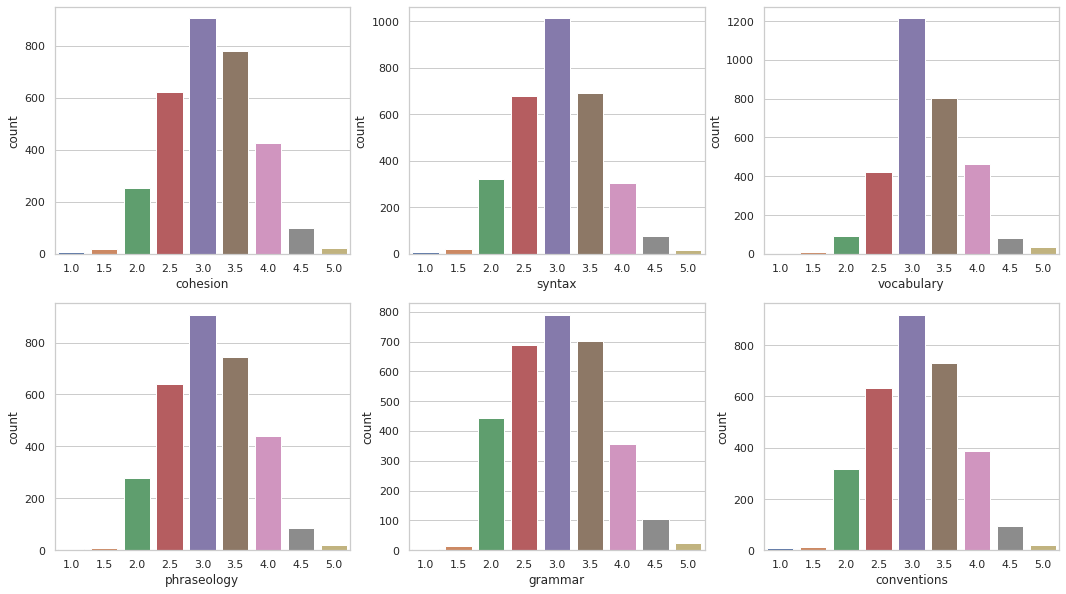

In [72]:
plot_count(df_train, label_cols)

## **Value Counts for Each Rounded Label**

In [73]:
get_value_counts_for_labels(df_train, label_rounded_cols)

Counts for Each Metric:
Column: cohesion_rounded_val
1.0       7
5.0      23
2.0     890
3.0     906
4.0    1302
Name: cohesion_rounded_val, dtype: int64
*****
Column: syntax_rounded_val
1.0       6
5.0      16
3.0    1011
2.0    1022
4.0    1073
Name: syntax_rounded_val, dtype: int64
*****
Column: vocabulary_rounded_val
1.0       1
5.0      35
2.0     529
3.0    1214
4.0    1349
Name: vocabulary_rounded_val, dtype: int64
*****
Column: phraseology_rounded_val
1.0       6
5.0      21
3.0     906
2.0     926
4.0    1269
Name: phraseology_rounded_val, dtype: int64
*****
Column: grammar_rounded_val
1.0       4
5.0      23
3.0     789
2.0    1146
4.0    1166
Name: grammar_rounded_val, dtype: int64
*****
Column: conventions_rounded_val
1.0      10
5.0      19
3.0     918
2.0     966
4.0    1215
Name: conventions_rounded_val, dtype: int64
*****


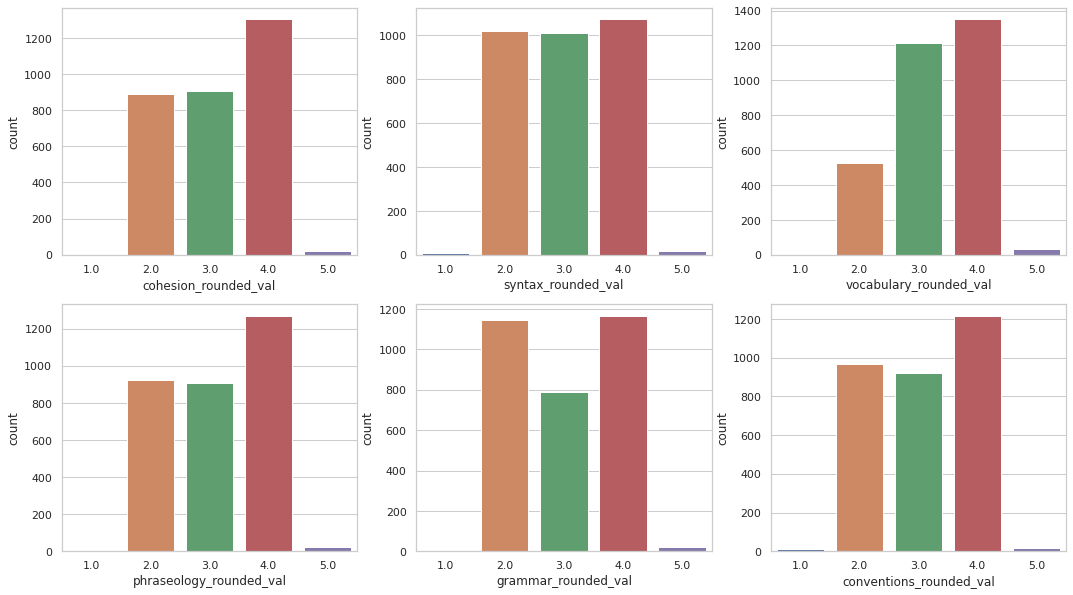

In [74]:
plot_count(df_train, label_rounded_cols)

## **Full Text Length Stats**

In [75]:
df_train.full_text.str.len().describe()

count    3128.000000
mean     2325.288683
std      1039.939247
min        82.000000
25%      1584.750000
50%      2160.000000
75%      2864.250000
max      6044.000000
Name: full_text, dtype: float64

## **Word Count Stats**

In [76]:
df_train.word_count.describe()

count    3128.000000
mean      429.276215
std       193.335886
min        14.000000
25%       292.000000
50%       401.000000
75%       525.250000
max      1260.000000
Name: word_count, dtype: float64

## **Sentence Count Stats**

In [77]:
df_train.sentence_count.describe()

count    3128.000000
mean       18.285486
std        10.366240
min         1.000000
25%        10.000000
50%        17.000000
75%        24.000000
max        90.000000
Name: sentence_count, dtype: float64

In [78]:
df_train[df_train.sentence_count == 1][['full_text']]

,full_text
39,my name is Generic_Name and my story is about ...
2933,yes becuase students would have more time to t...
1373,"We can't remove the impressions of the mind, a..."
3679,the memorable teacher ever had was a teache...
1139,A small kindness can change a person because i...
3607,Being yourself doesn't depends in how people s...
3025,Teachers should not be able design the student...
1161,People who value self they have defrine indidu...
2250,"when people ask for advice, sometimes seeking ..."
3134,Mr; Generic_Name please let me explain The ben...


# **Visualization**

## **Corelation Matrix of the Label Columns**

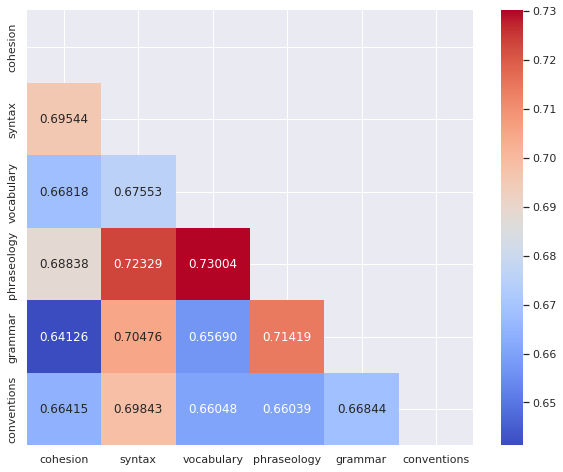

In [79]:
corr = df_train[label_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype = bool))

sns.set(rc = {"figure.figsize": (10, 8)})

sns.heatmap(corr, 
            annot = True, 
            cmap = "coolwarm", 
            mask = mask,
            fmt  = ".5f")
plt.show()

## **Essay Length, Word Count, Total Score, Sentence Count Distribution**

Essay length, word count and sentence count diostributions have normal shape, though left skewed. Total score distribution looks bi-modal.

Text(0.5, 1.0, 'Sentence Count Distribution')

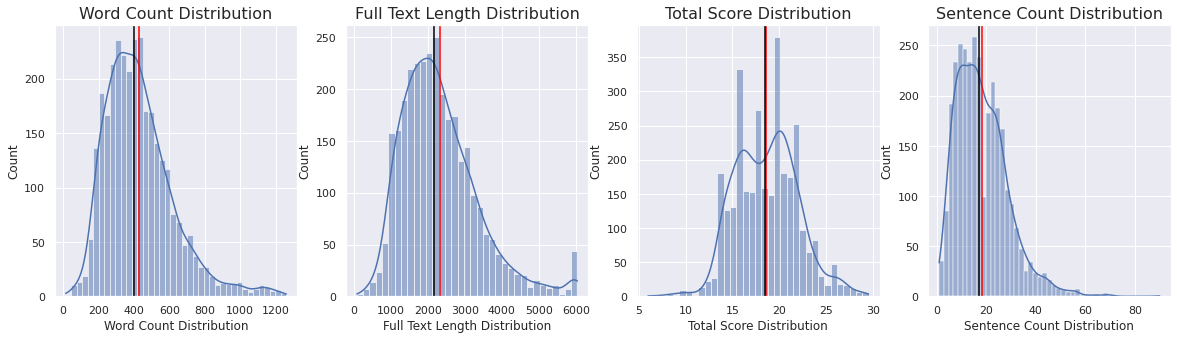

In [80]:
plt.figure(figsize=(20,5))

plt.subplot(1,4,1)
sns.histplot(data=df_train, x='word_count', kde=True)
plt.axvline(x=df_train['word_count'].mean(),color='red')
plt.axvline(x=df_train['word_count'].median(),color='black')
plt.xlabel('Word Count Distribution',fontsize=12)
plt.title('Word Count Distribution',fontsize=16)

plt.subplot(1,4,2)
sns.histplot(data=df_train, x='full_text_len', kde=True)
plt.axvline(x=df_train['full_text_len'].mean(),color='red')
plt.axvline(x=df_train['full_text_len'].median(),color='black')
plt.xlabel('Full Text Length Distribution',fontsize=12)
plt.title('Full Text Length Distribution',fontsize=16)

plt.subplot(1,4,3)
sns.histplot(data=df_train, x='total_score', kde=True)
plt.axvline(x=df_train['total_score'].mean(),color='red')
plt.axvline(x=df_train['total_score'].median(),color='black')
plt.xlabel('Total Score Distribution',fontsize=12)
plt.title('Total Score Distribution',fontsize=16)

plt.subplot(1,4,4)
sns.histplot(data=df_train, x='sentence_count', kde=True)
plt.axvline(x=df_train['sentence_count'].mean(),color='red')
plt.axvline(x=df_train['sentence_count'].median(),color='black')
plt.xlabel('Sentence Count Distribution',fontsize=12)
plt.title('Sentence Count Distribution',fontsize=16)

## **Word Count Vs Individual Label Scores**

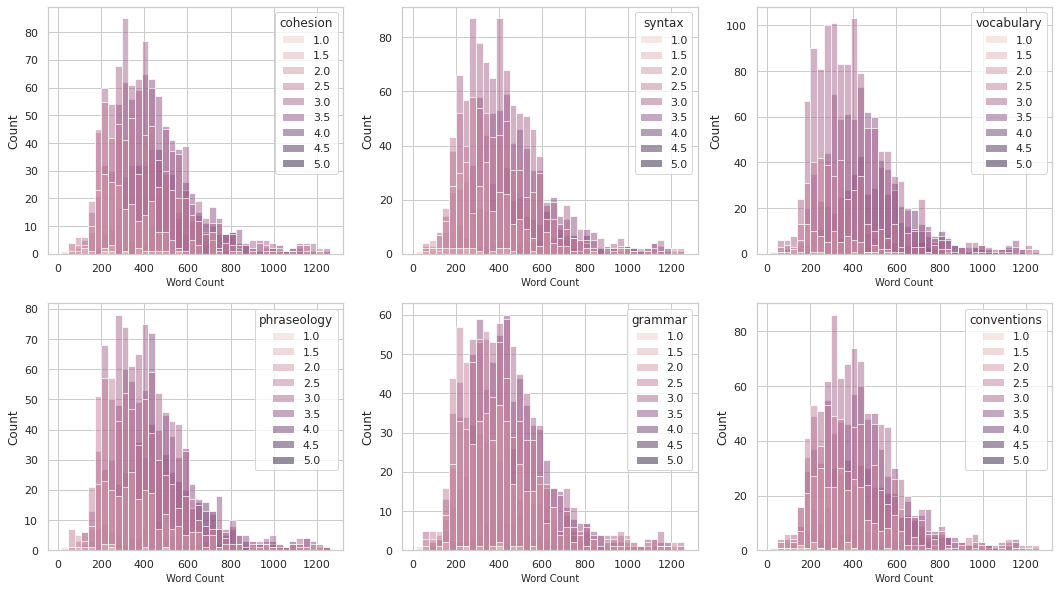

In [81]:
get_histogram_for_col(df_train, label_cols, 'word_count')

## **Word Count Vs Individual Rounded Label Scores**

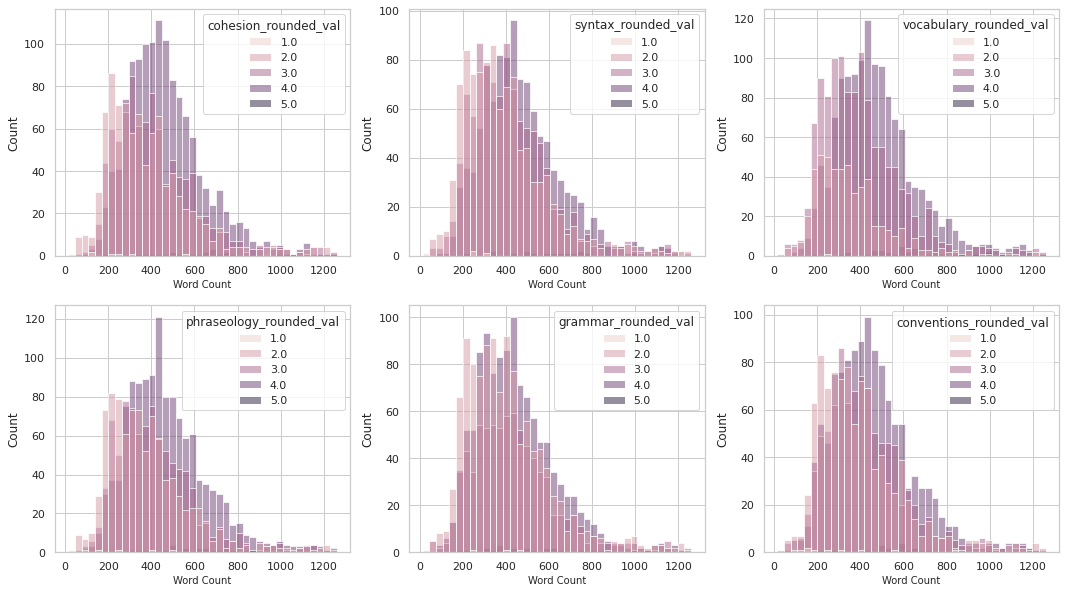

In [82]:
get_histogram_for_col(df_train, label_rounded_cols, 'word_count')

## **Sentence Count Vs Individual Label Scores**

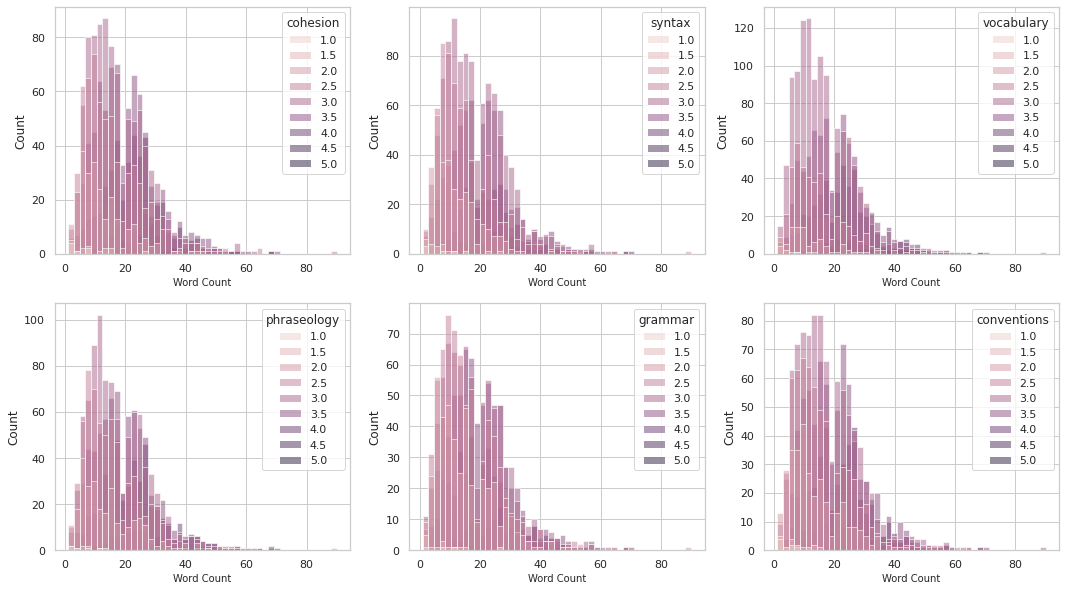

In [83]:
get_histogram_for_col(df_train, label_cols, 'sentence_count')

## **Sentence Count Vs Individual Rounded Label Scores**

In [ ]:
get_histogram_for_col(df_train, label_rounded_cols, 'sentence_count')

## **Distribution of Labels Above and Below Average in the Respective Category**

In [ ]:
get_count_plot_for_ind_col(df_train, '_above_or_below_avg_flag', label_cols)

## **Distribution of Labels Above and Below Median in the Respective Category**

In [ ]:
get_count_plot_for_ind_col(df_train, '_above_or_below_median_flag', label_cols)

For all the labels we see that most of the label values are below average and median values.

## **Distribution of Labels**

In [ ]:
fig, ax = plt.subplots(1, len(label_cols), figsize=(40,10))

for idx, label in enumerate(label_cols):
    sns.distplot(x = df_train[label],
                 ax = ax[idx]
                )
    ax[idx].set_title(label)
    #plt.show(block = False)

## **Average Score Per Label**

In [ ]:
get_barplot_for_each_label(df_train, label_cols, '_avg_score')

## **Median Score Per Label**

In [ ]:
get_barplot_for_each_label(df_train, label_cols, '_median_score')

## **Most Frequent Words**

In [ ]:
text = df_train[df_train[label_cols].sum(axis=1)==30]['full_text'].values[0]
word_cloud = WordCloud(stopwords=STOPWORDS, colormap='Pastel1', collocations=False, width=1200, height=700, background_color = "black").generate(text)
plt.figure(figsize=(20,8))
plt.imshow(word_cloud)
plt.axis("off")
plt.show()
     

# **Model Building**

- BASE_MODEL = "camembert-base"
- LEARNING_RATE = 2e-5
- MAX_LENGTH = 256
- BATCH_SIZE = 16
- EPOCHS = 20

In [ ]:
#make it easier to use a variety of BERT subword models
model_checkpoint = 'bert-base-cased'   # case sensitive (care about upper and lower case)
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
MAX_LENGTH = 512

In [ ]:
df_train.head(2)
df_train.iloc[:, 1:7].head(2)
label_cols

## Split Data into Train/Validation/Test Set

In [ ]:
X_train, X_val, X_test = df_train['full_text'], df_val['full_text'], df_test['full_text']
y_train, y_val, y_test = np.array(df_train[label_cols]), np.array(df_val[label_cols]), np.array(df_test[label_cols])

# # For Classification with 9 classes (0-8)
# # Handling map columns, this maintains the same number of levels as present in the original kpi sets.
# y_train_map, y_val_map, y_test_map = np.array(df_train[label_map_cols]), np.array(df_val[label_map_cols]), np.array(df_test[label_map_cols])
# y_train_map_combined = get_label_dict(df_train, label_map_cols, cat_label_cols)
# y_test_map_combined = get_label_dict(df_test, label_map_cols, cat_label_cols)
# y_val_map_combined = get_label_dict(df_val, label_map_cols, cat_label_cols)

# # For Classification with 5 classes (1-5)
# # Handling scaled values. Here we are converting the decimal values to nearest integers.
# # Thus .5, 1.5, 2.5, 3.5 and 4.5 map to 1, 2, 3, 4 and 5 respectively.
# y_train_scaled, y_val_scaled, y_test_scaled = np.array(df_train[label_rounded_cols]), np.array(df_val[label_rounded_cols]), np.array(df_test[label_rounded_cols])
# y_train_scaled_combined = get_label_dict(df_train, label_rounded_cols, cat_label_cols)
# y_test_scaled_combined = get_label_dict(df_test, label_rounded_cols, cat_label_cols)
# y_val_scaled_combined = get_label_dict(df_val, label_rounded_cols, cat_label_cols)

## **Generate Input Embeddings** - Train/Validation/Test Set

In [ ]:
train_encodings = bert_tokenizer(X_train.tolist(), dtype="int32", truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors='tf')
val_encodings = bert_tokenizer(X_val.tolist(), dtype="int32", truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors='tf')
test_encodings = bert_tokenizer(X_test.tolist(), dtype="int32", truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors='tf')

## Generate Dictionaries for Loss and Metrics for Regression

In [ ]:
regression_loss_dict = {label : 'huber_loss' for label in label_cols}
# regression_loss_dict = {label : 'rmse' for label in label_cols}
regression_loss_dict

In [40]:
regression_metrics_dict = {label : tf.keras.metrics.RootMeanSquaredError() for label in label_cols}
regression_metrics_dict

{'cohesion': <keras.metrics.metrics.RootMeanSquaredError at 0x7f494a47cf10>,
 'syntax': <keras.metrics.metrics.RootMeanSquaredError at 0x7f494aded160>,
 'vocabulary': <keras.metrics.metrics.RootMeanSquaredError at 0x7f494aded3d0>,
 'phraseology': <keras.metrics.metrics.RootMeanSquaredError at 0x7f494aded6d0>,
 'grammar': <keras.metrics.metrics.RootMeanSquaredError at 0x7f494a5a8580>,
 'conventions': <keras.metrics.metrics.RootMeanSquaredError at 0x7f494a5a8e20>}

# Heesuk's Questions:
- why **huber loss** (could use RMSE as well)?
- do we need to set **activation=None** for regression instead?
- need to consistent with **MAX_LENGTH=512** across all owners => let's be consistent in applyiing the same values for hyperparam

  - diff num of unfreezing layers = 2, 6, or 12
  - batch size = 8 or 16
  - diff learning rate = 0.00001, 0.00005, or 0.0001
  - size of hidden layer = upto 3 layers, units = up to 512
  - dropout rate = 0.1, 0.3, or 0.5
  - num_classes = 5 (np.ceil) 1-5 or 9 (0-8):
    - For regression - use 9 classes as is
- Use the same features (mean score, median score etc.)
- Test train/test vs test/valid/test split


In [ ]:
# def create_bert_model(checkpoint = model_checkpoint,
#                       num_classes = 9,   # [1, 1.5, 2, 2.5....4.5, 5]: 9 classes
#                       number_of_hidden_layer = 1,
#                       hidden_layer_node_count = 256,
#                       dropout = 0.3,
#                       learning_rate = 0.00001,
#                       trainable_flag = True,
#                       retrain_layer_count = 999,#All layers are trainable
#                       classification_regression_flag = 'C',
#                       max_length = MAX_LENGTH):
#     """
#     Build a simple classification model with BERT. Use the Pooler Output for classification purposes.
#     """
#     set_config_param()
#     bert_model = TFBertModel.from_pretrained(checkpoint, name = 'bert_model')    
#     if trainable_flag:
#         if retrain_layer_count == 999:
#             # Train all layers of the BERT model
#             bert_model.trainable = True         
#         else:
#             retrain_layers_list = []
#             for retrain_layer_number in range(retrain_layer_count):
#                 retrain_layers_list.append('retrain_layer_' + str(retrain_layer_number)) 
#             print('retrain layers: ', retrain_layers_list)

#             for weight in bert_model.weights:
#                 if not any([x in weight.name for layer in retrain_layers_list]):
#                     #print('freezing: ', w)
#                     weight._trainable = False
#     else:
#         # Freeze all layers of pre-trained BERT model
#         bert_model.trainable = False 
    
#     # Input layer
#     input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
#     token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
#     attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

#     bert_inputs = {'input_ids': input_ids,
#                    'token_type_ids': token_type_ids,
#                    'attention_mask': attention_mask}
                   
#     # Bert output: being used as an input feature in the classification model below
#     bert_out = bert_model(bert_inputs)        # full features as an input to the following classification model
#     # pooler_output = bert_out[1]             # one vector for each
#     cls_token = bert_out[0][:, 0, :]          # give us a raw CLS tokens

#     # =========== END generate "input features" using BERT tokenizer ==================================

#     # =========== BEGIN build a "multi-classification model" below passing the BERT input features ======
#     layer_list = []
#     for hidden_layer_number in range(number_of_hidden_layer):
#         if hidden_layer_number == 0:
#             hidden_layer = tf.keras.layers.Dense(units = hidden_layer_node_count
#                                                , activation = 'relu'
#                                                , name = 'hidden_layer_' + str(hidden_layer_number + 1)
#                                                 )(cls_token)
#         else:
#             hidden_layer = tf.keras.layers.Dense(units = hidden_layer_node_count
#                                                , activation = 'relu'
#                                                , name = 'hidden_layer_' + str(hidden_layer_number + 1)
#                                                 )(layer_list[-1])
#         layer_list.append(hidden_layer)
#         #dropout_layer = tf.keras.layers.Dropout(dropout, name = 'dropout_layer_' + str(hidden_layer_number + 1))(hidden_layer) 
#         #layer_list.append(dropout_layer)

#     if number_of_hidden_layer > 0:
#         dropout_layer = tf.keras.layers.Dropout(dropout, name = 'dropout_layer')(hidden_layer) 
#         layer_list.append(dropout_layer)

#     if classification_regression_flag == 'C':
#         # Output classification layer
#         classification_cohesion = tf.keras.layers.Dense(num_classes, activation = 'softmax', name = 'cat_cohesion')(layer_list[-1]) 
#         classification_syntax = tf.keras.layers.Dense(num_classes, activation = 'softmax', name = 'cat_syntax')(layer_list[-1])
#         classification_vocabulary = tf.keras.layers.Dense(num_classes, activation = 'softmax', name = 'cat_vocabulary')(layer_list[-1])
#         classification_phraseology = tf.keras.layers.Dense(num_classes, activation = 'softmax', name = 'cat_phraseology')(layer_list[-1])
#         classification_grammar = tf.keras.layers.Dense(num_classes, activation = 'softmax', name = 'cat_grammar')(layer_list[-1])
#         classification_conventions = tf.keras.layers.Dense(num_classes, activation = 'softmax', name = 'cat_conventions')(layer_list[-1])

#         outputs = [classification_cohesion, 
#                    classification_syntax, 
#                    classification_vocabulary, 
#                    classification_phraseology, 
#                    classification_grammar, 
#                    classification_conventions
#                   ]
#         classification_model = tf.keras.Model(inputs = [input_ids, 
#                                                         token_type_ids, 
#                                                         attention_mask
#                                                        ], 
#                                               outputs = outputs
#                                              )
#         classification_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
#                                      loss = classification_loss_dict,
#                                      metrics = classification_metrics_dict
#                                     )                
#         return classification_model

#     elif classification_regression_flag == 'R':

#         # Output regression layer
#         regression_cohesion = tf.keras.layers.Dense(num_classes, activation = 'softmax', name = 'cat_cohesion')(layer_list[-1]) 
#         regression_syntax = tf.keras.layers.Dense(num_classes, activation = 'softmax', name = 'cat_syntax')(layer_list[-1])
#         regression_vocabulary = tf.keras.layers.Dense(num_classes, activation = 'softmax', name = 'cat_vocabulary')(layer_list[-1])
#         regression_phraseology = tf.keras.layers.Dense(num_classes, activation = 'softmax', name = 'cat_phraseology')(layer_list[-1])
#         regression_grammar = tf.keras.layers.Dense(num_classes, activation = 'softmax', name = 'cat_grammar')(layer_list[-1])
#         regression_conventions = tf.keras.layers.Dense(num_classes, activation = 'softmax', name = 'cat_conventions')(layer_list[-1])

#         outputs = [regression_cohesion, 
#                    regression_syntax, 
#                    regression_vocabulary, 
#                    regression_phraseology, 
#                    regression_grammar, 
#                    regression_conventions
#                   ]
#         regression_model = tf.keras.Model(inputs = [input_ids, 
#                                                     token_type_ids, 
#                                                     attention_mask
#                                                    ], 
#                                           outputs = outputs
#                                          )
#         regression_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
#                                  loss = regression_loss_dict,
#                                  metrics = regression_metrics_dict
#                                 )                
#         return regression_model

## **"bert_classification_model_1" is the baseline classification model with multilabel multi output(1..9). We are retraining the pre-trained model.**

In [ ]:
# bert_classification_model_1 = create_bert_model(checkpoint = model_checkpoint,
#                                                 num_classes = 9,   # [1, 1.5, 2, 2.5....4.5, 5]: 9 classes
#                                                 number_of_hidden_layer = 1,
#                                                 hidden_layer_node_count = 128,
#                                                 dropout = 0.3,
#                                                 learning_rate = 0.00001,
#                                                 trainable_flag = True,
#                                                 retrain_layer_count = 999,#All layers trainable
#                                                 classification_regression_flag = 'C',
#                                                 max_length = MAX_LENGTH
#                                               )

# print(bert_classification_model_1.summary())

In [ ]:
# keras.utils.plot_model(bert_classification_model_1, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90)

In [ ]:
# bert_classification_model_1_history = bert_classification_model_1.fit([train_encodings.input_ids, 
#                                                                        train_encodings.token_type_ids, 
#                                                                        train_encodings.attention_mask
#                                                                       ], 
#                                                                       y_train_map_combined,   
#                                                                       validation_data =([val_encodings.input_ids, 
#                                                                                          val_encodings.token_type_ids, 
#                                                                                          val_encodings.attention_mask
#                                                                                         ], 
#                                                                                         y_val_map_combined
#                                                                                       ),    
#                                                                       batch_size = 8, 
#                                                                       epochs = 5
#                                                                      )                                                  
# bert_classification_model_1_history_df = pd.DataFrame(bert_classification_model_1_history.history)
# bert_classification_model_1_history_df.T

In [ ]:
# score_classification_model_1 = bert_classification_model_1.evaluate([test_encodings.input_ids, 
#                                                                      test_encodings.token_type_ids, 
#                                                                      test_encodings.attention_mask
#                                                                     ], 
#                                                                     y_test_map_combined
#                                                                    ) 

# print('Test loss:', score_classification_model_1[0]) 
# print('Test accuracy:', score_classification_model_1[1])

In [ ]:
# predictions_classification_model_1 = bert_classification_model_1.predict([test_encodings.input_ids, 
#                                                                           test_encodings.token_type_ids, 
#                                                                           test_encodings.attention_mask
#                                                                           ]
#                                                                          )
# predictions_classification_model_1 = np.clip(predictions_classification_model_1, 0, 8)
# predictions_classification_model_1

In [ ]:
# plot_loss_accuracy(bert_classification_model_1_history_df, cat_label_cols)

## **"bert_classification_model_2" is the baseline classification model with multilabel multi output. We are freezing the pre-trained model.**

In [ ]:
# bert_classification_model_2 = create_bert_model(checkpoint = model_checkpoint,
#                                                 num_classes = 9,   # [1, 1.5, 2, 2.5....4.5, 5]: 9 classes
#                                                 number_of_hidden_layer = 1,
#                                                 hidden_layer_node_count = 128,
#                                                 dropout = 0.3,
#                                                 learning_rate = 0.00001,
#                                                 trainable_flag = False,
#                                                 retrain_layer_count = 999,#All layers trainable
#                                                 classification_regression_flag = 'C',
#                                                 max_length = MAX_LENGTH
#                                               )

# print(bert_classification_model_2.summary())

In [ ]:
# keras.utils.plot_model(bert_classification_model_2, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90)

In [ ]:
# bert_classification_model_2_history = bert_classification_model_2.fit([train_encodings.input_ids, 
#                                                                        train_encodings.token_type_ids, 
#                                                                        train_encodings.attention_mask
#                                                                       ], 
#                                                                       y_train_map_combined,   
#                                                                       validation_data =([val_encodings.input_ids, 
#                                                                                          val_encodings.token_type_ids, 
#                                                                                          val_encodings.attention_mask
#                                                                                         ], 
#                                                                                         y_val_map_combined
#                                                                                       ),    
#                                                                       batch_size = 8, 
#                                                                       epochs = 5
#                                                                      )                                                  
# bert_classification_model_2_history_df = pd.DataFrame(bert_classification_model_2_history.history)
# bert_classification_model_2_history_df.T

In [ ]:
# score_classification_model_2 = bert_classification_model_2.evaluate([test_encodings.input_ids, 
#                                                                      test_encodings.token_type_ids, 
#                                                                      test_encodings.attention_mask
#                                                                     ], 
#                                                                     y_test_map_combined
#                                                                    ) 

# print('Test loss:', score_classification_model_2[0]) 
# print('Test accuracy:', score_classification_model_2[1])

In [ ]:
# predictions_classification_model_2 = bert_classification_model_2.predict([test_encodings.input_ids, 
#                                                                           test_encodings.token_type_ids, 
#                                                                           test_encodings.attention_mask
#                                                                           ]
#                                                                          )
# predictions_classification_model_2 = np.clip(predictions_classification_model_2, 0, 8)
# predictions_classification_model_2

In [ ]:
# plot_loss_accuracy(bert_classification_model_2_history_df, cat_label_cols)

## **"bert_classification_model_3" is the baseline classification model with multilabel multi output (1..5). We are un-freezing the pre-trained model and running with scaled output levels.**

In [ ]:
# bert_classification_model_3 = create_bert_model(checkpoint = model_checkpoint,
#                                                 num_classes = 5,   # [1, 1.5, 2, 2.5....4.5, 5]: 9 classes
#                                                 number_of_hidden_layer = 1,
#                                                 hidden_layer_node_count = 128,
#                                                 dropout = 0.3,
#                                                 learning_rate = 0.00001,
#                                                 trainable_flag = True,
#                                                 retrain_layer_count = 999,#All layers trainable
#                                                 classification_regression_flag = 'C',
#                                                 max_length = MAX_LENGTH
#                                               )

# print(bert_classification_model_3.summary())

In [ ]:
# keras.utils.plot_model(bert_classification_model_3, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90)

In [ ]:
# bert_classification_model_3_history = bert_classification_model_3.fit([train_encodings.input_ids, 
#                                                                        train_encodings.token_type_ids, 
#                                                                        train_encodings.attention_mask
#                                                                       ], 
#                                                                       y_train_scaled_combined,   
#                                                                       validation_data =([val_encodings.input_ids, 
#                                                                                          val_encodings.token_type_ids, 
#                                                                                          val_encodings.attention_mask
#                                                                                         ], 
#                                                                                         y_val_scaled_combined
#                                                                                       ),    
#                                                                       batch_size = 8, 
#                                                                       epochs = 5
#                                                                      )                                                  
# bert_classification_model_3_history_df = pd.DataFrame(bert_classification_model_3_history.history)
# bert_classification_model_3_history_df.T

In [ ]:
# score_classification_model_3 = bert_classification_model_3.evaluate([test_encodings.input_ids, 
#                                                                      test_encodings.token_type_ids, 
#                                                                      test_encodings.attention_mask
#                                                                     ], 
#                                                                     y_test_scaled_combined
#                                                                    ) 

# print('Test loss:', score_classification_model_3[0]) 
# print('Test accuracy:', score_classification_model_3[1])

In [ ]:
# predictions_classification_model_3 = bert_classification_model_3.predict([test_encodings.input_ids, 
#                                                                           test_encodings.token_type_ids, 
#                                                                           test_encodings.attention_mask
#                                                                           ]
#                                                                          )
# predictions_classification_model_3 = np.clip(predictions_classification_model_3, 1, 5)
# predictions_classification_model_3

In [ ]:
# plot_loss_accuracy(bert_classification_model_3_history_df, cat_label_cols)

# Regression Model with BERT
- **Model 1:** Freeze all the 12 BERT layers
- **Model 2:** Unfreeze 6 layers
- **Model 3:** Unfreeze 12 layers

[Regression with Text Input Using BERT and Transformers](https://lajavaness.medium.com/regression-with-text-input-using-bert-and-transformers-71c155034b13)

## Model Checkpoint and **Tokenization** from Pre-trained Model

In [43]:
from transformers import BertTokenizer, TFBertModel

model_checkpoint == 'bert-base-cased'                                      
bert_model = TFBertModel.from_pretrained(model_checkpoint)            # case sensitive (care about upper and lower case)
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)

## Define **Hyperparameter Values** at Global Level

In [ ]:
MAX_LENGTH = 512
NUM_CLASSES = 9

In [ ]:
import random

NUM_TRAIN_LAYERS = 12       # [unfreeze 2, 6, 12]
NUM_HIDDEN_UNITS = 256           # [upto 3 layers, up to 512 units, 32, 64, 128, 256, 512]
DROPOUT = 0.3               # [0.1, 0.3, or 0.5]
LEARNING_RATE = 0.00005     # [0.00001, 0.00005, or 0.000001]
EPOCHS = 5                  # or 10
BATCH_SIZE = 8              # or 16

# num_classes=NUM_CLASSES,   # [0,1,2,...8]: 9 classes 
# num_train_layers=random.choice([2,6,12]),
# num_hidden_layer = 1
# num_hidden_units=random.choice([64,128,256]),
# dropout=random.choice([0.1, 0.3, 0.4]),
# learning_rate=random.choice([0.00005, 0.00001, 0.000001]),
# max_length=MAX_LENGTH

# print(f'num_train_layers = {num_train_layers}\nnum_hidden_units = {num_hidden_units}\ndropout = {dropout}\nlearning_rate = {learning_rate}')

In [ ]:
def regression_model_with_bert(num_classes=9,   # [0,1,2,...8]: 9 classes or [1,2,3,4,5] 5 classes
                               num_train_layers=NUM_TRAIN_LAYERS,
                               num_hidden_layer = 1,
                               num_hidden_units=NUM_HIDDEN_UNITS,
                               dropout=DROPOUT,
                               learning_rate=LEARNING_RATE,
                               max_length=MAX_LENGTH):

    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes.
    """
    # =========== BEGIN generate "input features" using pre-trained model tokenizer ==================================
    # bert_model = TFBertModel.from_pretrained(checkpoint)    
    if num_train_layers == 0:
        bert_model.trainable = False                 # Freeze all layers of pre-trained BERT model

    elif num_train_layers == 12:         
        bert_model.trainable = True                  # Train all layers of the BERT model

    else:                                            # Restrict training to the num_train_layers outer transformer layers
        retrain_layers = []
        for retrain_layer_number in range(num_train_layers):
            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code) 
        print('retrain layers: ', retrain_layers)

        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                #print('freezing: ', w)
                w._trainable = False
    
    # Input Layer
    input_ids = tf.keras.layers.Input(shape=(MAX_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    # token_type_ids = tf.keras.layers.Input(shape=(MAX_LENGTH,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                  # 'token_type_ids': token_type_ids,
                  'attention_mask': attention_mask
                  }
                      
    # Bert output: being used as an input feature in the classification model below
    bert_out = bert_model(bert_inputs)        # full features as an input to the following classification model
    # pooler_output = bert_out[1]             # one vector for each
    cls_token = bert_out[0][:, 0, :]          # give us a raw CLS tokens


    layer_list = []
    for hidden_layer_number in range(num_hidden_layer):
        if hidden_layer_number == 0:
            hidden_layer = tf.keras.layers.Dense(units = num_hidden_units
                                        , activation = 'relu'
                                        , name = 'hidden_layer_' + str(hidden_layer_number + 1)
                                        )(cls_token)
        else:
            hidden_layer = tf.keras.layers.Dense(units = num_hidden_units
                                        , activation = 'relu'
                                        , name = 'hidden_layer_' + str(hidden_layer_number + 1)
                                        )(layer_list[-1])
        layer_list.append(hidden_layer)
        dropout_layer = tf.keras.layers.Dropout(dropout, name = 'dropout_layer_' + str(hidden_layer_number + 1))(hidden_layer) 
        layer_list.append(dropout_layer)

    output = tf.keras.layers.Dense(6,)(layer_list[-1])
    # regression_model = tf.keras.Model(inputs = [input_ids, token_type_ids, attention_mask], outputs = output)
    regression_model = tf.keras.Model(inputs = [input_ids,attention_mask], outputs = output)

    regression_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
                            loss=MCRMSE,
                            metrics=MCRMSE) 
    print(f'num_train_layers = {num_train_layers}\nnum_hidden_units = {num_hidden_units}\ndropout = {dropout}\nlearning_rate = {learning_rate}\n')
    return regression_model

## Baseline Regression Model with BERT

In [ ]:
baseline_regression_with_bert = regression_model_with_bert(num_train_layers=0)

def display_summary_and_plot_model(model):
  print(model.summary())
  keras.utils.plot_model(model, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90)
  
display_summary_and_plot_model(baseline_regression_with_bert)

num_train_layers = 0
num_hidden_units = 256
dropout = 0.3
learning_rate = 5e-05

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['attention_mask_layer[0][0]',   
                                thPoolingAndCrossAt               'input_ids_layer[0][0]']        
           

In [ ]:
def train_regression(model):
  regression_model_history = baseline_regression_with_bert.fit([train_encodings.input_ids, 
                                                  #  train_encodings.token_type_ids, 
                                                  train_encodings.attention_mask
                                                  ], 
                                                  y_train,   
                                                  validation_data =([val_encodings.input_ids, 
                                                                    #  val_encodings.token_type_ids, 
                                                                    val_encodings.attention_mask
                                                                    ], 
                                                                    y_val
                                                                  ),    
                                                  batch_size = 8, 
                                                  epochs = 1
                                                  )                                                  
  regression_model_df = pd.DataFrame(regression_model_history.history)
  return regression_model_df.T

train_regression(baseline_regression_with_bert)

391/391 [==============================] - 166s 394ms/step - loss: 1.0692 - MCRMSE: 1.0692 - val_loss: 0.5592 - val_MCRMSE: 0.5592


,0
loss,1.069210
MCRMSE,1.069210
val_loss,0.559177
val_MCRMSE,0.559198


In [ ]:
score_regression_model = baseline_regression_with_bert.evaluate([test_encodings.input_ids, 
                                                                    #  test_encodings.token_type_ids, 
                                                                     test_encodings.attention_mask
                                                                    ], 
                                                                    y_test
                                                                   ) 

print(score_regression_model)

13/13 [==============================] - 15s 1s/step - loss: 0.5768 - MCRMSE: 0.5739
[0.5767552256584167, 0.5738707184791565]


In [ ]:
predictions_regression_model = baseline_regression_with_bert.predict([test_encodings.input_ids, 
                                                                          # test_encodings.token_type_ids, 
                                                                          test_encodings.attention_mask
                                                                          ]
                                                                         )
print(predictions_regression_model)

13/13 [==============================] - 15s 1s/step
[[3.153287  3.042438  3.1277082 2.9638433 3.031097  3.2329588]
 [3.078813  3.0355694 3.428224  2.9115627 3.226047  3.0156572]
 [3.098581  3.0248582 2.9818907 2.8439183 3.0161924 3.2607121]
 ...
 [3.3394096 3.3537858 3.536563  3.156961  3.4144995 3.5738237]
 [3.0958269 3.1091125 2.9480515 3.0026398 3.1980014 2.9733233]
 [3.2009943 3.0348573 3.332755  3.101759  3.1711628 3.4599245]]


In [ ]:
df_test[label_cols]

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
3317,3.5,2.5,3.5,3.5,2.5,3.0
3172,3.0,3.0,3.0,3.5,2.5,3.0
2999,2.5,2.0,2.5,2.0,2.0,3.0
2824,3.5,3.0,3.0,2.5,2.5,3.5
310,2.5,2.5,2.5,2.0,2.5,2.0
...,...,...,...,...,...,...
70,2.5,3.0,3.0,3.0,2.5,2.0
1767,3.5,3.0,3.5,3.0,3.5,4.0
2424,3.0,3.5,3.5,4.0,4.0,4.0
3204,3.0,3.0,3.0,3.0,3.0,2.5


In [ ]:
regression_model_df

,loss,MCRMSE,val_loss,val_MCRMSE
0,1.06413,1.06413,0.627251,0.627205


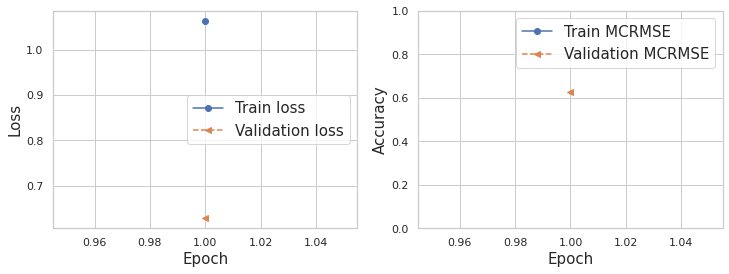

In [ ]:
x_arr = np.arange(len(regression_model_df['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, regression_model_df['loss'], '-o', label='Train loss')
ax.plot(x_arr, regression_model_df['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, regression_model_df['MCRMSE'], '-o', label='Train MCRMSE')
ax.plot(x_arr, regression_model_df['val_MCRMSE'], '--<', label='Validation MCRMSE')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
ax.set_ylim(0,1)
plt.show()